In [1]:
%pip install ipynb
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from matplotlib.colors import LogNorm
import heapq as heap
from pprint import pprint

import math

# Constants
MOTIF_MATRIX_IMAGE = '../res/motif_matrix.png'
TEMPORAL_MOTIF_EXTRACTOR_PATH = "/home/aakyildiz/snap/examples/temporalmotifs/temporalmotifsmain"

Note: you may need to restart the kernel to use updated packages.


## Utility functions

### split graph by period

In [2]:
def split_graph_by_period(input_graph_path, output_path, time_period):
    '''
    Splits a temporal graph into multiple temporal graphs each taking up `time_period` seconds
    
    input_graph_path: the location of the edgelist that is space delimeted and contains (u,v,timestamp) tuples
    output_path: the path in which the garphs will be printed out
    
    Will produce the following files/folders
        {output_path}/periodical_graphs/period_{time_period}/0to{time_period}/0to{time_period}.edgelist
        {output_path}/periodical_graphs/period_{time_period}/0to{time_period}/{time_period}to{2*time_period}.edgelist
        ...
    
    Returns:
        The path of the location of the partitioned graphs (path/to/period_{time_period})
    
    '''
    # make output directory if it's not already made
    output_path+='periodical_graphs'
    res = os.popen("mkdir -p "+output_path)
    graph = pd.read_csv(input_graph_path, header=None, index_col = False, sep=' ')
    graph.columns = ['u', 'v', 'time']
    graph.sort_values('time', inplace=True)
    start_time = graph.iloc[0]['time']
    end_time = graph.iloc[graph.shape[0]-1]['time']
    output_period_folder = output_path+"/period_"+str(time_period)
    for i in range(start_time, end_time, time_period):
        part_name = str(i)+"to"+str(i+time_period)
        output_part_folder = output_period_folder+"/"+part_name+"/"
        res = os.popen("mkdir -p "+output_part_folder)
        this_g = graph[graph['time'] >= i]
        this_g = this_g[this_g['time']<i+time_period]
        #print(output_part_folder+part_name+'.edgelist')
        this_g.to_csv(output_part_folder+part_name+'.edgelist', sep=' ', header=False, index=False)
    return output_period_folder

### extract temporal motifs from a graph 

In [3]:
def extract_temporal_motifs(input_graph_path, output_location, numThreads=32, delta=60):
    '''
    Given a single input graph and an output motifs matrix locaion, will print the 
    motifs matrix and return the motifs as an matrix
    '''
    #parameters
    numThreads = str(numThreads)
    delta = str(delta)
    
    #out_path = input_graph_path.split(".")[0] + "-delta=" + delta + ".temporalmotifs"
    command = TEMPORAL_MOTIF_EXTRACTOR_PATH + " -i:" + input_graph_path \
                                            + " -nt:"  + numThreads\
                                            + " -delta:"  + delta\
                                            + " -o:" + output_location
    res = os.popen(command)
    res.read()
    motifs = []
    maxc = 0
    numnegatives = 0
    with open(output_location, "r") as f:
        for line in f:
            counts = line.replace("\n", "").split(" ")
            temp = []
            for count in counts:
                if float(count) > 0:
                    maxc = float(count)
                temp.append(count)
            motifs.append(temp)
        for i in range(len(motifs)):
            for j in range(len(motifs[i])):
                motifs[i][j] = float(motifs[i][j])
                if motifs[i][j] < 0: #fix snap 32bit int bug, re-set negative counts as the maximum positive count
                    numnegatives += 1
                    motifs[i][j] = maxc
        print("Number of negatives:", numnegatives) # important
    return motifs

### Motif heatmap viewer

In [4]:
def display_motifs_heatmap(motifs, image_path=None, figname=None, title=None):
    mmax = np.max(motifs)
    mmin = 1 #np.min(motifs)
    print(mmax, mmin)
    
    # open the image 
    # Import image and get x and y extents
    def remove_ticks(ax):
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])

    cmap = plt.cm.get_cmap('Blues', len(np.unique(motifs)))
    if image_path is not None:
        img = plt.imread(image_path)
        x_ext = img.shape[1]/100.0
        y_ext = img.shape[0]/100.0
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        ax2.imshow(img, alpha=1, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.imshow(motifs, cmap=cmap, alpha = 0.3, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.set_aspect('equal')
        remove_ticks(ax2)
    else:
        fig, ax1 = plt.subplots()
    yticklabels = [str(i) for i in reversed(range(len(motifs)))]
    sns.heatmap(motifs, cmap=cmap, annot=True, fmt=".1f", ax=ax1, yticklabels=yticklabels, norm=LogNorm(vmin=mmin, vmax=mmax))    
    ax1.set_aspect('equal')
    fig.set_size_inches(12,5)
    remove_ticks(ax1)
    if title is not None:
        fig.suptitle(title, fontsize=20)
    plt.show()
    if figname != None:
        fig.savefig(figname, dpi=300, bbox_inches='tight')


### Evolutionary temporal viewer

In [5]:
def evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta, partitioned_graphs_location):
    '''
    Takes a graph and produces time-evolutionary temporal motifs based on the input and produces the 
    output temporal motifs
    '''
    def sort_folders_by_number(folders):
        start_and_folder = [(int(a.split('to')[0]), a) for a in folders]
        return [folder for _, folder in sorted(start_and_folder)]
    location = split_graph_by_period(input_graph_path, partitioned_graphs_location, time_period)
    for part_folder in sort_folders_by_number(list(os.listdir(location))):
        files_prefix = location+'/'+part_folder+'/'+part_folder
        input_graph = files_prefix+'.edgelist'
        temporal_motifs_name=files_prefix+'-delta='+str(delta)
        temporal_motifs_matrix = temporal_motifs_name+'.temporalmotifs'
        emporal_motifs_figure=temporal_motifs_name+'.png'
        display_motifs_heatmap(extract_temporal_motifs(input_graph, output_location=temporal_motifs_matrix,delta=delta),
                               MOTIF_MATRIX_IMAGE, figname=emporal_motifs_figure, title=part_folder)

## tests

In [6]:
input_graph_path = "/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist"
time_period = 60*60*24*90 # 90 day periods 
#output_folder = "/DATA/7A/assets/erc721networks/GodsUnchainedCards/"
output_folder = "/DATA/7A/assets/erc721networks/Rarible/Rarible"
hour = 3600
minute = 60
motifs = extract_temporal_motifs(input_graph_path, output_folder + ".temporalmotifs", 32, hour)
#evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=60)
#evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=3600, partitioned_graphs_location=output_folder)

Number of negatives: 0


---

---

---

# Analysis

### load categories

In [15]:
categories = {
    "marketplace" : 0,
    "games" : 1,
    "exchange" : 2,
    "defi" : 3,
    "social": 4,
    "gambling": 5,
}
categories_rev = {
    0: "marketplace",
    2: "exchange",
    3: "defi",
    4: "social",
    5: "gambling",
    1: "games",
}
new_categories = {
    "voting" : 0,
    "resource" : 1,
    "collectible" : 2,
    "utility" : 3,
}
new_categories_rev = {
    0: "voting",
    1: "resource",
    2: "collectible",
    3: "utility",
}

### load dapps

In [16]:
#load dapps
dapps = [
    {
        "path": "/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist",
        "folder_path": "/DATA/7A/assets/erc721networks/Rarible/",
        #"category": categories["marketplace"],
        "category": new_categories["collectible"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc721networks/SuperRare/SuperRare.edgelist",
        "folder_path": "/DATA/7A/assets/erc721networks/SuperRare/",
        #"category": categories["marketplace"],
        "category": new_categories["collectible"],
        "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc721networks/DecentralandLAND/DecentralandLAND.edgelist",
        "folder_path": "/DATA/7A/assets/erc721networks/DecentralandLAND/",
        #"category": categories["marketplace"],
        "category": new_categories["collectible"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties.edgelist",
        "folder_path": "/DATA/7A/assets/erc721networks/CryptoKitties/",
        #"category": categories["games"],
        "category": new_categories["collectible"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards.edgelist",
        "folder_path": "/DATA/7A/assets/erc721networks/GodsUnchainedCards/",
        #"category": categories["games"],
        "category": new_categories["collectible"],
         "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc721networks/Sorare/Sorare.edgelist",
        "folder_path": "/DATA/7A/assets/erc721networks/Sorare/",
        #"category": categories["games"],
        "category": new_categories["collectible"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc20networks/UniswapV2/UniswapV2.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/UniswapV2/",
        #"category": categories["exchange"],
        "category": new_categories["voting"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc20networks/SushiToken/SushiToken.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/SushiToken/",
        #"category": categories["exchange"],
        "category": new_categories["voting"],
        "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc20networks/Uniswap/Uniswap.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/Uniswap/",
        #"category": categories["exchange"],
        "category": new_categories["voting"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc20networks/Compound/Compound.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/Compound/",
        "category": new_categories["voting"],
        #"category": categories["defi"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc20networks/yearnfinance/yearnfinance.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/yearnfinance/",
        "category": new_categories["voting"],
        #"category": categories["defi"],
        "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/ChiGastokenby1inch/",
        #"category": categories["defi"],
        "category": new_categories["voting"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc20networks/LivepeerToken/LivepeerToken.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/LivepeerToken/",
        #"category": categories["social"],
        "category": new_categories["resource"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc20networks/Minds/Minds.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/Minds/",
        #"category": categories["social"],
        "category": new_categories["utility"],
        "id": 1
    },
    #{
    #    "path": "/DATA/7A/assets/erc20networks/Minds/Minds.edgelist",
    #    "category": categories["social"],
    #    "id": 2
    #},
    {
        "path": "/DATA/7A/assets/erc20networks/BetterBetting/BetterBetting.edgelist",
        "folder_path": "/DATA/7A/assets/erc20networks/BetterBetting/",
        #"category": categories["gambling"],
        "category": new_categories["utility"],
        "id": 0
    },
]

## Dapp motif similarity 

### get motif frequencies of dapps

/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist
Number of negatives: 0
418171.0 1


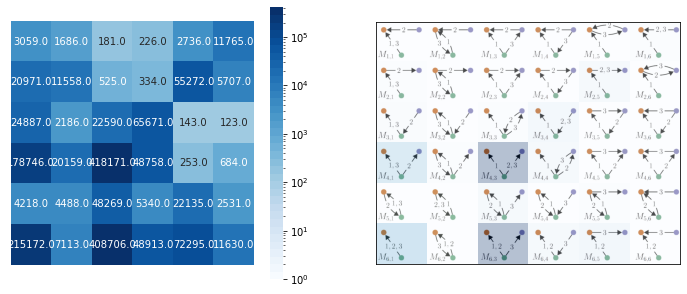

/DATA/7A/assets/erc721networks/SuperRare/SuperRare.edgelist
Number of negatives: 0
552678.0 1


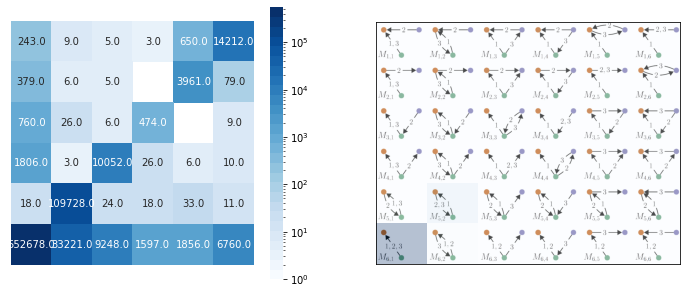

/DATA/7A/assets/erc721networks/DecentralandLAND/DecentralandLAND.edgelist
Number of negatives: 0
1916442898.0 1


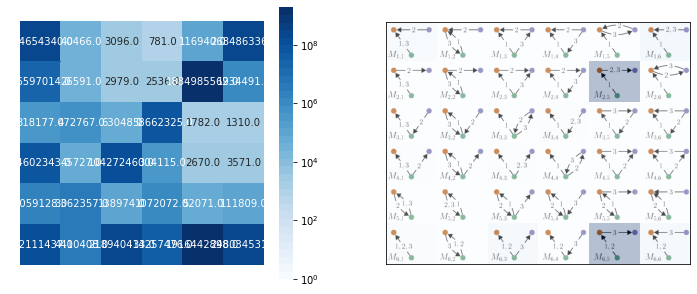

/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties.edgelist
Number of negatives: 6
2095068010.0 1


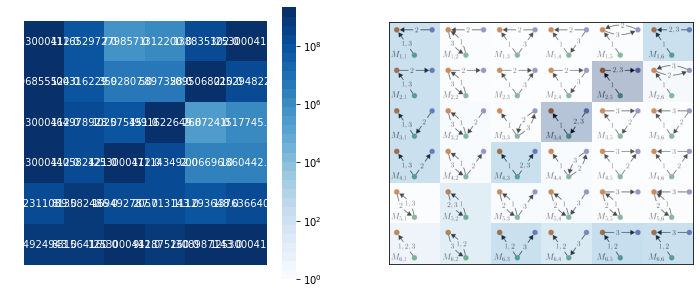

/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards.edgelist
Number of negatives: 5
1882920389.0 1


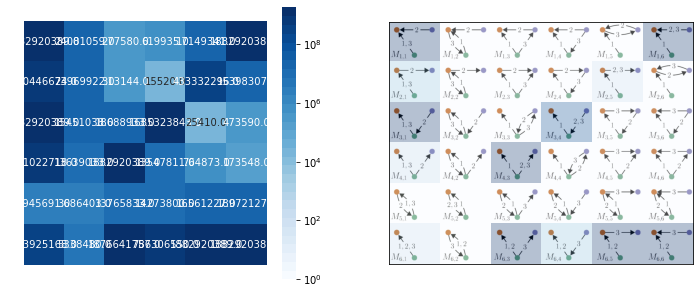

/DATA/7A/assets/erc721networks/Sorare/Sorare.edgelist
Number of negatives: 3
486091543.0 1


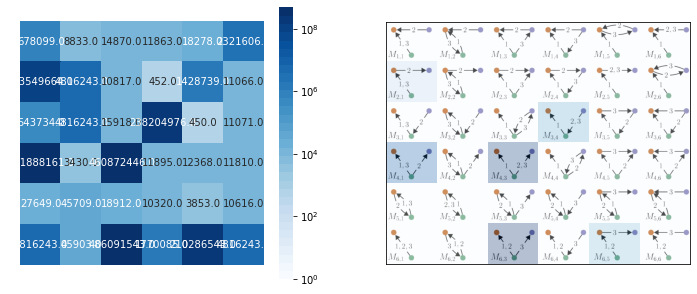

/DATA/7A/assets/erc20networks/UniswapV2/UniswapV2.edgelist
Number of negatives: 0
565635948.0 1


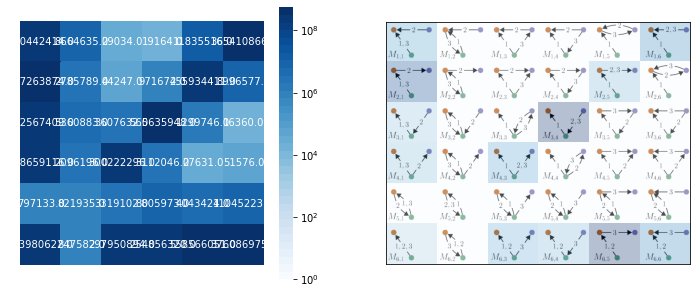

/DATA/7A/assets/erc20networks/SushiToken/SushiToken.edgelist
Number of negatives: 3
1657716729.0 1


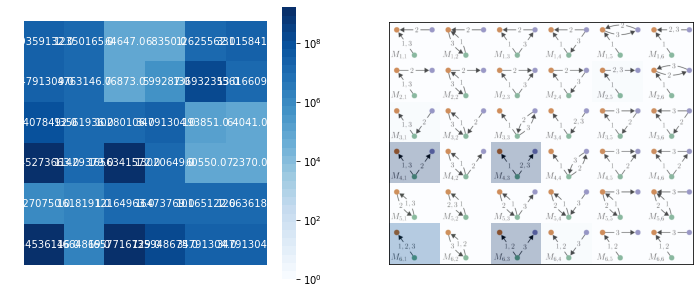

/DATA/7A/assets/erc20networks/Uniswap/Uniswap.edgelist
Number of negatives: 0
141415089.0 1


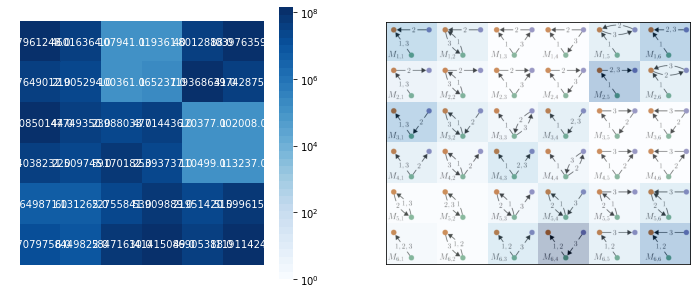

/DATA/7A/assets/erc20networks/Compound/Compound.edgelist
Number of negatives: 0
29158797.0 1


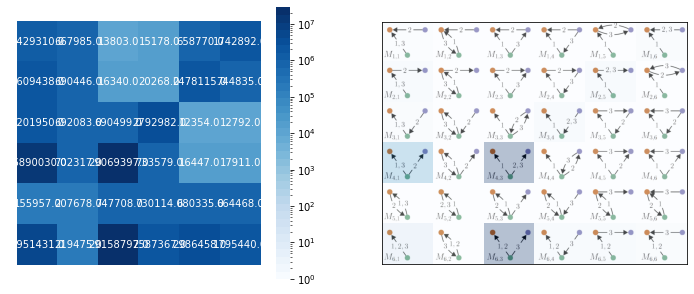

/DATA/7A/assets/erc20networks/yearnfinance/yearnfinance.edgelist
Number of negatives: 0
25067356.0 1


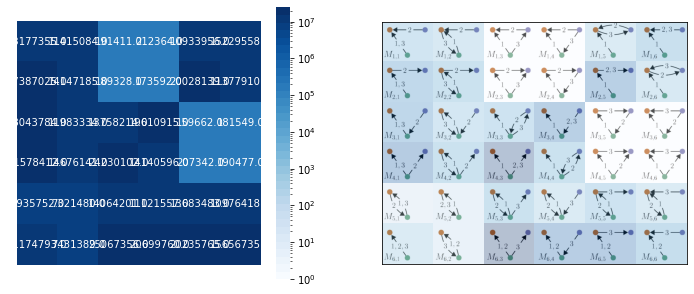

/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch.edgelist
Number of negatives: 4
629556478.0 1


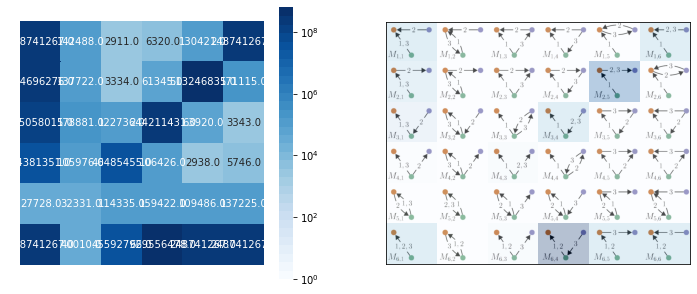

/DATA/7A/assets/erc20networks/LivepeerToken/LivepeerToken.edgelist
Number of negatives: 6
1463085882.0 1


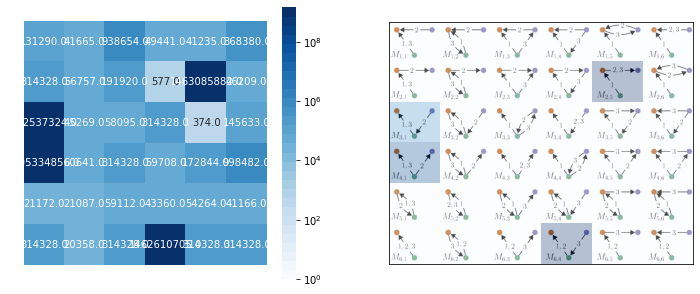

/DATA/7A/assets/erc20networks/Minds/Minds.edgelist
Number of negatives: 0
48753.0 1


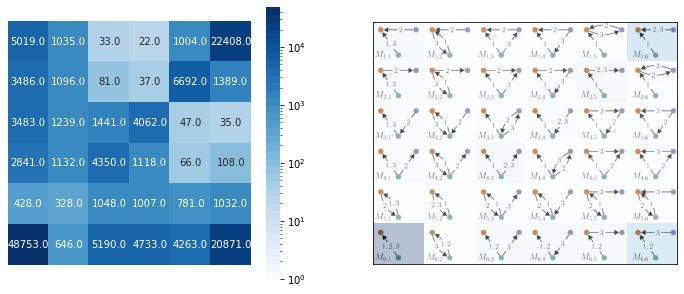

/DATA/7A/assets/erc20networks/BetterBetting/BetterBetting.edgelist
Number of negatives: 0
142914.0 1


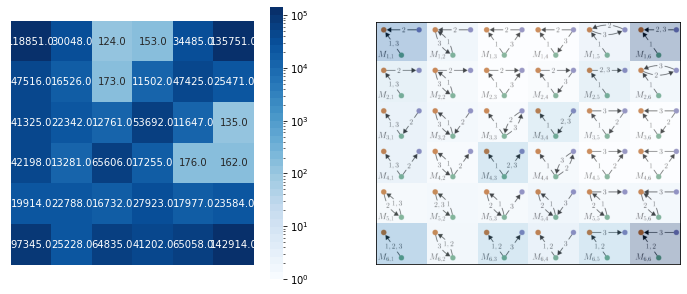

In [17]:
hour = 3600
for i in range(len(dapps)):
    print(dapps[i]["path"])
    graph_path = dapps[i]["path"].split(".")[0]
    dapps[i]["motifs"] = extract_temporal_motifs(dapps[i]["path"], graph_path + ".temporalmotifs", 32, hour)
    #print(dapps[i]["motifs"])
    display_motifs_heatmap(dapps[i]["motifs"], image_path=MOTIF_MATRIX_IMAGE, figname=graph_path + ".temporalmotifs" + ".png", title=None)
    

### plot motif frequency distribution per each dapp

4


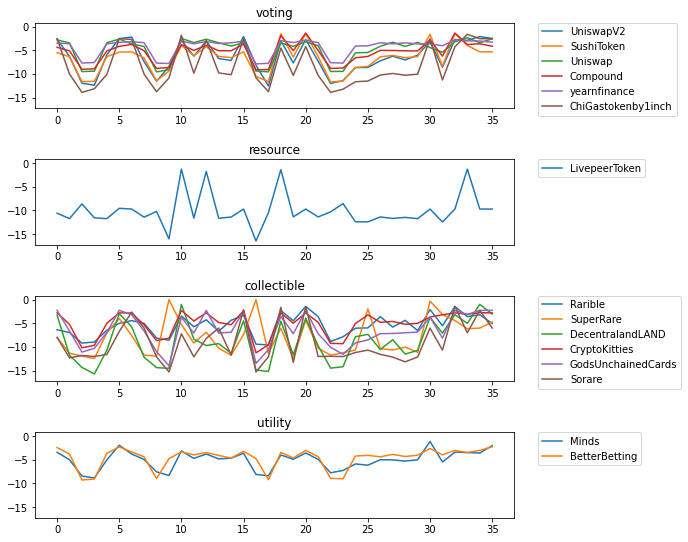

In [19]:
x = [m for m in range(36)]

fig, axs = plt.subplots(len(new_categories), sharey=True, figsize=(8,8))
#fig, axs = plt.subplots(1, sharey=True, figsize=(15,8))
fig.tight_layout(pad=3.0)

print(len(axs))
for i in range(len(axs)):
    axs[i].set(title=new_categories_rev[i])


for dapp in dapps:
    total_motif_count = 0
    for row in dapp["motifs"]:
        for count in row:
            total_motif_count += count
    y = []
    for row in dapp["motifs"]:
        for count in row:
            if count == 0.0:
                y.append(count)
            else:
                #y.append(math.log(count))
                y.append(math.log(count / total_motif_count))
                #y.append(count )
    axs[dapp["category"]].plot(x, y, label = dapp["path"].split(".")[0].split("/")[-1])
    #axs.plot(x, y, label = dapp["path"].split(".")[0].split("/")[-1])
    axs[dapp["category"]].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.legend()
plt.show()
        

### get nth highest ranked motifs

In [20]:
def get_nth_largest(motifs, nth=5):
    ranks = []
    heap.heapify(ranks)

    for i in range(len(motifs)):
        row = motifs[i]
        for j in range(len(row)):
            val = row[j]
            if len(ranks) < nth:
                heap.heappush(ranks, (val, i, j))
            else:
                heap.heappushpop(ranks, (val, i, j))
    return ranks

nth = 12
for i in range(len(dapps)):
    dapps[i]["ranks"] = get_nth_largest(dapps[i]["motifs"], nth)

### display highest ranked motifs per Dapp

36 18


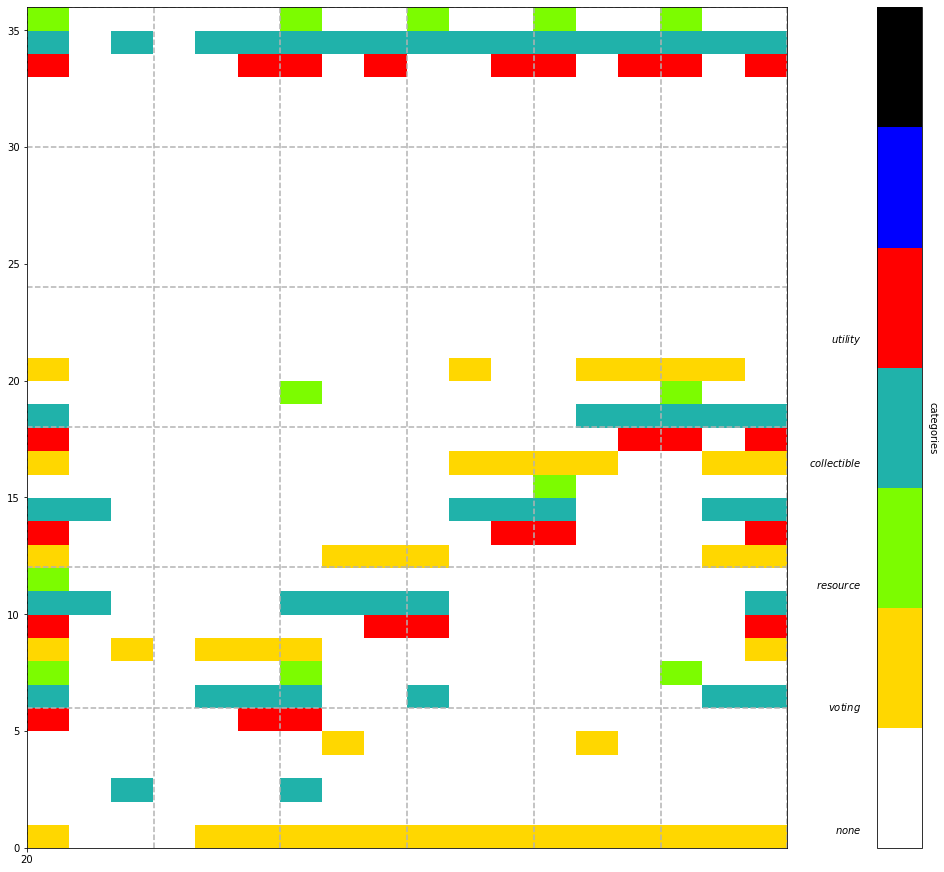

In [23]:
motifs_width = 6
motifs_length = 6
max_number_of_dapp_per_category = 3

def fill_map(ranks, mat, category, graph):
    for r in ranks:
        #print(r[1] * 5 + category, r[2] * 5 + graph, category)
        mat[(motifs_width - r[1] - 1) * len(new_categories) - category][r[2] * max_number_of_dapp_per_category - graph] = category + 1

def plot_map(colormaps, data):
    """
    Helper function to plot data with associated colormap.
    """
    
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * (nth + 1), nth),
                            constrained_layout=True, squeeze=False)
        
    #n = len(colormaps)
    #fig, axs = plt.subplots(1, n, figsize=(n * (nth-2) + 2, nth),
                            #constrained_layout=True, squeeze=False)

    for [ax, cmap] in zip(axs.flat, colormaps):
        vlines = np.linspace(0,len(data[0]),motifs_width+1)[1:]
        hlines = np.linspace(0,len(data), motifs_length+1)[1:]
        for xx in vlines:
            ax.axvline(xx, color='0.7', linestyle='--')
        for xx in hlines:
            ax.axhline(xx, color='0.7', linestyle='--')
        ax.axvline("20", color='1', linestyle='--')
        
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=6)
        cb = plt.colorbar(psm, ax=ax, label = "categories")
        cb.ax.get_yaxis().set_ticks([])
        #for j, lab in enumerate(["$none$", "$marketplace$", "$games$", "$exchange$", "$defi$", "$social$", "$gambling$"]):
        for j, lab in enumerate(["$none$", "$voting$", "$resource$", "$collectible$", "$utility$"]):
            cb.ax.text(-2, (7 * j + 1) / 8.0, lab, ha='right', va='center')
        cb.ax.get_yaxis().labelpad = 15
        cb.ax.set_ylabel('categories', rotation=270)
        
        #cb.set_ticklabels()

    plt.show()
    
mat = np.zeros((motifs_width * len(categories), motifs_length * max_number_of_dapp_per_category))
print(len(mat), len(mat[0]))

for dapp in dapps:
    fill_map(dapp["ranks"], mat, dapp["category"], dapp["id"])
np.set_printoptions(threshold=sys.maxsize)

cmap = ListedColormap(["white", "gold", "lawngreen", "lightseagreen", "red", "blue", "black"])
plot_map([cmap], mat)

### cluster dapps using motifs as features

In [160]:
from sklearn.cluster import KMeans
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import SpectralClustering

features = []
for i in range(len(dapps)):
    print(dapps[i]["path"])
    #total_motif_count = 0
    #for row in dapps[i]["motifs"]:
    #    for count in row:
    #        total_motif_count += count
    #y = []
    #for row in dapps[i]["motifs"]:
    #    for count in row:
    #        if count == 0.0:
    #            y.append(count)
    #        else:
    #            #y.append(math.log(count))
    #            y.append(count)
    #            #y.append(count )
    #    dapps[i]["motifs_romajor"] = y
    #features.append(y)

    y = []
    for rank in dapps[i]["ranks"]:
        y.append(rank[1] * 6 + rank[2])
    features.append(y)
    dapps[i]["rankss"] = y
    print(y)

print(len(features), len(features[0]))
cls = SpectralClustering(n_clusters = 6)
cls.fit_predict(features)
#for dapp in dapps:
#    print(categories_rev[dapp["category"]])
#    print(cls.fit_predict([dapp["rankss"]]))
    

/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist
[14, 12, 21, 26, 10, 33, 32, 20, 30, 18, 34, 15]
/DATA/7A/assets/erc721networks/SuperRare/SuperRare.edgelist
[12, 33, 18, 20, 34, 32, 30, 31, 25, 35, 10, 5]
/DATA/7A/assets/erc721networks/DecentralandLAND/DecentralandLAND.edgelist
[18, 15, 0, 20, 30, 32, 34, 7, 1, 35, 10, 5]
/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties.edgelist
[33, 0, 6, 12, 18, 5, 34, 15, 35, 20, 10, 32]
/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards.edgelist
[30, 18, 6, 0, 12, 15, 33, 34, 20, 35, 32, 5]
/DATA/7A/assets/erc721networks/Sorare/Sorare.edgelist
[33, 7, 5, 13, 30, 18, 6, 32, 35, 15, 34, 20]
/DATA/7A/assets/erc20networks/UniswapV2/UniswapV2.edgelist
[12, 18, 32, 33, 10, 5, 6, 0, 15, 20, 35, 34]
/DATA/7A/assets/erc20networks/SushiToken/SushiToken.edgelist
[5, 15, 6, 34, 10, 20, 35, 33, 12, 18, 30, 32]
/DATA/7A/assets/erc20networks/Uniswap/Uniswap.edgelist
[4, 27, 11, 0, 32, 29, 20, 35, 12, 33, 10, 5]
/DATA/7A/assets/

/home/aakyildiz/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


array([5, 3, 3, 2, 1, 3, 5, 4, 0, 2, 3, 0, 0, 5, 1], dtype=int32)

### Comments
- Although there are some negative counts the largest negative count per graph is 6. The results on the above plot is acceptable if nth >= 6
- 

### Ideas
- collaborative filtering (motifs as films, dapps as users) to find the similarity of dapps.
    - which ones do you think should be similar (what can we analyze about this)
- logistic regression to predict dapp category? we definitely need more data

## Dapp highest ranked motif evolution

### generate split

In [61]:
period = 60 * 60 * 24 * 90 # 90 days

In [27]:
def sort_folders_by_number(folders):
    start_and_folder = [(int(a.split('to')[0]), a) for a in folders]
    return [folder for _, folder in sorted(start_and_folder)]

for i in range(len(dapps)):
    pmotif_path = dapps[i]["path"].split(".")[0] + "/"
    output_path = split_graph_by_period(dapps[i]["path"], pmotif_path, period)
    pfiles = sort_folders_by_number(list(os.listdir(output_path)))
    pfiles = list(map(lambda x: output_path + "/" + x + "/" + x + ".edgelist", pfiles))
    dapps[i]["periodical_graph_paths"] = pfiles #sort_folders_by_number()
    #print(pmotif_path)
    #print(output_path)
    for path in dapps[i]["periodical_graph_paths"]:
        print(path)         

/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/0to7776000/0to7776000.edgelist
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.edgelist
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/15552000to23328000/15552000to23328000.edgelist
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/23328000to31104000/23328000to31104000.edgelist
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/31104000to38880000/31104000to38880000.edgelist
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/38880000to46656000/38880000to46656000.edgelist
/DATA/7A/assets/erc721networks/SuperRare/SuperRare/periodical_graphs/period_7776000/0to7776000/0to7776000.edgelist
/DATA/7A/assets/erc721networks/SuperRare/SuperRare/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.edgelist
/DATA/7A/ass

/DATA/7A/assets/erc20networks/yearnfinance/yearnfinance/periodical_graphs/period_7776000/0to7776000/0to7776000.edgelist
/DATA/7A/assets/erc20networks/yearnfinance/yearnfinance/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.edgelist
/DATA/7A/assets/erc20networks/yearnfinance/yearnfinance/periodical_graphs/period_7776000/15552000to23328000/15552000to23328000.edgelist
/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch/periodical_graphs/period_7776000/0to7776000/0to7776000.edgelist
/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.edgelist
/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch/periodical_graphs/period_7776000/15552000to23328000/15552000to23328000.edgelist
/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch/periodical_graphs/period_7776000/23328000to31104000/23328000to31104000.edgelist
/DATA/7A/assets/erc20networks/Livepe

### get periodical temporal motifs of dapps

In [30]:
an_hour = 3600

for i in range(len(dapps)):
    dapps[i]["periodical_motifs"] = []
    for path in dapps[i]["periodical_graph_paths"]:
        tmotif_path = path.split(".")[0] + ".temporalmotifs"
        motif = motifs = extract_temporal_motifs(path, tmotif_path, numThreads=32, delta=an_hour)
        print(tmotif_path)
        print(motif)
        dapps[i]["periodical_motifs"].append((tmotif_path, motifs))

Number of negatives: 0
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/0to7776000/0to7776000.temporalmotifs
[[0.0, 0.0, 0.0, 0.0, 1.0, 289.0], [22.0, 0.0, 0.0, 0.0, 70.0, 2.0], [10.0, 0.0, 0.0, 17.0, 0.0, 0.0], [2.0, 0.0, 35.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [604.0, 0.0, 41.0, 2.0, 47.0, 195.0]]
Number of negatives: 0
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.temporalmotifs
[[167.0, 78.0, 34.0, 20.0, 125.0, 515.0], [2100.0, 347.0, 20.0, 158.0, 4084.0, 47.0], [1038.0, 158.0, 349.0, 4769.0, 51.0, 13.0], [2843.0, 382.0, 6211.0, 597.0, 14.0, 59.0], [709.0, 931.0, 700.0, 121.0, 435.0, 7.0], [32137.0, 841.0, 5935.0, 3196.0, 4791.0, 508.0]]
Number of negatives: 0
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/15552000to23328000/15552000to23328000.temporalmotifs
[[178.0, 46.0, 18.0, 13.0, 71.0, 802.0], [706.0, 247.0, 2.0, 6.0, 2461.0, 93.0]

Number of negatives: 6
/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties/periodical_graphs/period_7776000/0to7776000/0to7776000.temporalmotifs
[[1960136378.0, 91167351.0, 27815.0, 42191.0, 118721669.0, 502286507.0], [313573588.0, 65738625.0, 68018.0, 13701.0, 560758398.0, 177886487.0], [1532657798.0, 135362633.0, 85879277.0, 562714867.0, 11652.0, 40524.0], [1481006306.0, 97311909.0, 560758398.0, 128821388.0, 86329.0, 71199.0], [2406654.0, 4638073.0, 128362905.0, 178108316.0, 85375673.0, 118518118.0], [560758398.0, 4484499.0, 560758398.0, 560758398.0, 560758398.0, 560758398.0]]
Number of negatives: 0
/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.temporalmotifs
[[189753758.0, 3378036.0, 21753.0, 29267.0, 3928453.0, 316906424.0], [106487947.0, 2104547.0, 41348.0, 51074.0, 67568250.0, 6964810.0], [21935942.0, 6205510.0, 2842088.0, 202364219.0, 28704.0, 34265.0], [395543553.0, 5875703.0, 508127235.0, 

Number of negatives: 6
/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.temporalmotifs
[[1279088584.0, 6254508.0, 4426.0, 3253.0, 2546818.0, 2079360754.0], [132736156.0, 6417841.0, 3956.0, 1066.0, 132736156.0, 3576866.0], [132736156.0, 3428224.0, 3371165.0, 132736156.0, 1353.0, 7869.0], [1417363165.0, 2967095.0, 148407592.0, 3232273.0, 550652.0, 3374.0], [1000532.0, 1657032.0, 3360860.0, 3423400.0, 4768503.0, 5514806.0], [2104216682.0, 2221034.0, 137880735.0, 132736156.0, 132736156.0, 132736156.0]]
Number of negatives: 0
/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards/periodical_graphs/period_7776000/15552000to23328000/15552000to23328000.temporalmotifs
[[4478480.0, 56972.0, 418.0, 149.0, 28067.0, 9510005.0], [10743088.0, 46082.0, 13613.0, 189.0, 31287542.0, 1614.0], [24235198.0, 4362.0, 31556.0, 13255184.0, 467.0, 37.0], [42102606.0, 4189.0, 291964420.0, 1399.0, 302.0, 302.0], 

Number of negatives: 0
/DATA/7A/assets/erc20networks/SushiToken/SushiToken/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.temporalmotifs
[[2679296.0, 1484200.0, 18616.0, 19136.0, 1354826.0, 3827723.0], [35739305.0, 1437877.0, 23599.0, 20494.0, 4874850.0, 1350617.0], [2776631.0, 1746034.0, 1331078.0, 38303992.0, 13078.0, 20794.0], [114370533.0, 2024228.0, 120330003.0, 1682434.0, 18622.0, 21691.0], [335379.0, 620287.0, 1415370.0, 1662551.0, 1420240.0, 1169906.0], [112396348.0, 638437.0, 120543532.0, 5405363.0, 38332724.0, 3743009.0]]
Number of negatives: 0
/DATA/7A/assets/erc20networks/SushiToken/SushiToken/periodical_graphs/period_7776000/15552000to23328000/15552000to23328000.temporalmotifs
[[355446.0, 122286.0, 4227.0, 4262.0, 91829.0, 541046.0], [5390199.0, 110606.0, 2978.0, 2146.0, 697047.0, 90358.0], [369126.0, 166509.0, 91024.0, 6577112.0, 2159.0, 3285.0], [26884904.0, 250199.0, 33008255.0, 159138.0, 3094.0, 3761.0], [16684.0, 54988.0, 86844.0, 122188.0, 10274

Number of negatives: 0
/DATA/7A/assets/erc20networks/LivepeerToken/LivepeerToken/periodical_graphs/period_7776000/0to7776000/0to7776000.temporalmotifs
[[159.0, 2.0, 899.0, 108.0, 0.0, 340.0], [23960277.0, 0.0, 104.0, 0.0, 907388.0, 7.0], [903125.0, 0.0, 0.0, 23954423.0, 0.0, 481.0], [476780815.0, 0.0, 488682008.0, 0.0, 1175.0, 259.0], [0.0, 0.0, 0.0, 3.0, 0.0, 0.0], [479624919.0, 6.0, 480839055.0, 951761.0, 24270618.0, 509.0]]
Number of negatives: 6
/DATA/7A/assets/erc20networks/LivepeerToken/LivepeerToken/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.temporalmotifs
[[7890.0, 3.0, 934897.0, 48801.0, 0.0, 166051.0], [78829.0, 2.0, 184011.0, 3.0, 1459244164.0, 21.0], [891410138.0, 6.0, 0.0, 78829.0, 0.0, 152338.0], [589081879.0, 0.0, 78829.0, 1.0, 171234.0, 1000404.0], [1.0, 0.0, 3.0, 20.0, 2.0, 0.0], [78829.0, 1.0, 78829.0, 1464203027.0, 78829.0, 78829.0]]
Number of negatives: 0
/DATA/7A/assets/erc20networks/LivepeerToken/LivepeerToken/periodical_graphs/period_777

Number of negatives: 0
/DATA/7A/assets/erc20networks/Minds/Minds/periodical_graphs/period_7776000/77760000to85536000/77760000to85536000.temporalmotifs
[[16.0, 17.0, 0.0, 0.0, 19.0, 17.0], [56.0, 36.0, 0.0, 0.0, 86.0, 34.0], [74.0, 29.0, 36.0, 55.0, 0.0, 0.0], [100.0, 71.0, 195.0, 80.0, 0.0, 1.0], [17.0, 10.0, 148.0, 49.0, 54.0, 19.0], [25.0, 12.0, 204.0, 91.0, 55.0, 28.0]]
Number of negatives: 0
/DATA/7A/assets/erc20networks/BetterBetting/BetterBetting/periodical_graphs/period_7776000/0to7776000/0to7776000.temporalmotifs
[[110.0, 69.0, 0.0, 3.0, 47.0, 59.0], [402.0, 135.0, 0.0, 0.0, 260.0, 70.0], [364.0, 52.0, 147.0, 285.0, 0.0, 0.0], [26501.0, 62.0, 45530.0, 95.0, 2.0, 1.0], [78.0, 55.0, 112.0, 47.0, 77.0, 102.0], [538.0, 103.0, 48213.0, 169.0, 407.0, 124.0]]
Number of negatives: 0
/DATA/7A/assets/erc20networks/BetterBetting/BetterBetting/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.temporalmotifs
[[2748.0, 826.0, 1.0, 1.0, 1298.0, 4149.0], [946.0, 576.0, 2.0, 

### get highest ranked motifs for each periodical graph

In [57]:
nth = 1
for i in range(len(dapps)):
    dapps[i]["periodical_highest_ranked"] = []
    for pmotif in dapps[i]["periodical_motifs"]:
        fig_path = pmotif[0]
        dapps[i]["periodical_highest_ranked"].append(get_nth_largest(pmotif[1], nth))
        print(fig_path)
        print(dapps[i]["periodical_highest_ranked"])
        #display_motifs_heatmap(pmotif[1], image_path=MOTIF_MATRIX_IMAGE, figname=fig_path + ".png", title=None)

/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/0to7776000/0to7776000.temporalmotifs
[[(604.0, 5, 0)]]
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/7776000to15552000/7776000to15552000.temporalmotifs
[[(604.0, 5, 0)], [(32137.0, 5, 0)]]
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/15552000to23328000/15552000to23328000.temporalmotifs
[[(604.0, 5, 0)], [(32137.0, 5, 0)], [(83040.0, 5, 0)]]
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/23328000to31104000/23328000to31104000.temporalmotifs
[[(604.0, 5, 0)], [(32137.0, 5, 0)], [(83040.0, 5, 0)], [(132380.0, 3, 2)]]
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period_7776000/31104000to38880000/31104000to38880000.temporalmotifs
[[(604.0, 5, 0)], [(32137.0, 5, 0)], [(83040.0, 5, 0)], [(132380.0, 3, 2)], [(96767.0, 3, 2)]]
/DATA/7A/assets/erc721networks/Rarible/Rarible/periodical_graphs/period

### plot highest ranked motif evolution per dapp

/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist
[30, 30, 30, 20, 20, 20]
/DATA/7A/assets/erc721networks/SuperRare/SuperRare.edgelist
[30, 30, 30, 30, 30, 30, 30]
/DATA/7A/assets/erc721networks/DecentralandLAND/DecentralandLAND.edgelist
[15, 30, 30, 30, 30, 34, 30, 25, 31, 30, 30]
/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties.edgelist
[0, 30, 30, 32, 33, 30, 35, 10, 30, 30, 30, 30, 30, 32]
/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards.edgelist
[15, 30, 32, 30, 20, 20]
/DATA/7A/assets/erc721networks/Sorare/Sorare.edgelist
[30, 30, 30, 32, 30, 30, 30]
/DATA/7A/assets/erc20networks/UniswapV2/UniswapV2.edgelist
[32, 15, 15, 30]
/DATA/7A/assets/erc20networks/SushiToken/SushiToken.edgelist
[32, 32, 32]
/DATA/7A/assets/erc20networks/Uniswap/Uniswap.edgelist
[33, 33, 33]
/DATA/7A/assets/erc20networks/Compound/Compound.edgelist
[32, 32, 20, 20, 32]
/DATA/7A/assets/erc20networks/yearnfinance/yearnfinance.edgelist
[32, 34, 33]
/DATA/7A/assets/erc20networ

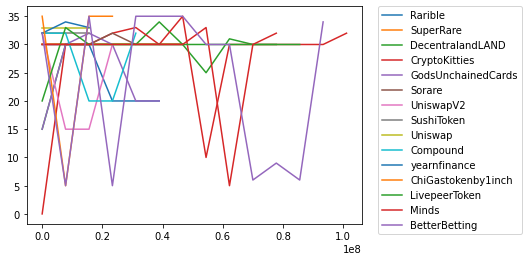

In [58]:
motifs_width = 6
motifs_length = 6
max_time_periods = 0
for i in range(len(dapps)):
    print(dapps[i]["path"])
    if len(dapps[i]["periodical_highest_ranked"]) > max_time_periods:
        max_time_periods = len(dapps[i]["periodical_highest_ranked"])
    x = []
    #for i in range(max_time_periods):
    #    x.append(i * period)
    #print(time_period_ticks)
    y = []
    cnt = 0
    for pmotifs in dapps[i]["periodical_highest_ranked"]:
        x.append(cnt * period)
        cnt += 1
        y.append(pmotifs[0][1] * motifs_width + pmotifs[0][2])
        #print(pmotif)
    print(y)
    plt.plot(x, y, label = dapps[i]["path"].split(".")[0].split("/")[-1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
        


### Comments
Honestly i couldnt interpret much on this result

### Ideas
 - 